# Run pathways in FaIR

The pathways are generated elsewhere, imported here and then run.

In [1]:
import json
from multiprocessing import Pool
import platform

from climateforcing.utils import mkdir_p
import fair
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
with open('../data_input/fair-1.6.2-ar6/fair-1.6.2-wg3-params.json') as f:
    config_list = json.load(f)

In [3]:
emissions_in = {}
results_out = {}
WORKERS = 3  # set this based on your individual machine - allows parallelisation. nprocessors-1 is a sensible shout.

In [4]:
scenarios = ["ssp245_constant-2020-ch4", "ch4_30", "ch4_40", "ch4_50", "coal-phase-out"]

In [5]:
for scenario in scenarios:
    emissions_in[scenario] = np.loadtxt('../data_output/fair_emissions_files/{}.csv'.format(scenario), delimiter=',')

## convenience function for running FaIR config with each emission species

In [6]:
def run_fair(args):
    thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
    return (thisC[:,0], thisC[:,1], thisT, thisF[:,1], np.sum(thisF, axis=1))

def fair_process(emissions):
    updated_config = []
    for i, cfg in enumerate(config_list):
        updated_config.append({})
        for key, value in cfg.items():
            if isinstance(value, list):
                updated_config[i][key] = np.asarray(value)
            else:
                updated_config[i][key] = value
        updated_config[i]['emissions'] = emissions
        updated_config[i]['diagnostics'] = 'AR6'
        updated_config[i]["efficacy"] = np.ones(45)
        updated_config[i]["gir_carbon_cycle"] = True
        updated_config[i]["temperature_function"] = "Geoffroy"
        updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
        updated_config[i]["fixPre1850RCP"] = False
    #    updated_config[i]["scale"][43] = 0.6
        updated_config[i]["F_solar"][270:] = 0
        
    # multiprocessing is not working for me on Windows
    if platform.system() == 'Windows':
        shape = (361, len(updated_config))
        c_co2 = np.ones(shape) * np.nan
        c_ch4 = np.ones(shape) * np.nan
        t = np.ones(shape) * np.nan
        f_ch4 = np.ones(shape) * np.nan
        f_tot = np.ones(shape) * np.nan
        for i, cfg in tqdm(enumerate(updated_config), total=len(updated_config), position=0, leave=True):
            c_co2[:,i], c_ch4[:,i], t[:,i], f_ch4[:,i], f_tot[:,i] = run_fair(updated_config[i])
    
    else:
        if __name__ == '__main__':
            with Pool(WORKERS) as pool:
                result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config), position=0, leave=True))

        result_t = np.array(result).transpose(1,2,0)
        c_co2, c_ch4, t, f_ch4, f_tot = result_t
    temp_rebase = t - t[100:151,:].mean(axis=0)
    
    return c_co2, c_ch4, temp_rebase, f_ch4, f_tot

## Do the runs

In [7]:
for scenario in tqdm(scenarios, position=0, leave=True):
    results_out[scenario] = {}
    (
        results_out[scenario]['co2_concentrations'],
        results_out[scenario]['ch4_concentrations'],
        results_out[scenario]['temperatures'],
        results_out[scenario]['ch4_effective_radiative_forcing'],
        results_out[scenario]['effective_radiative_forcing']
    ) = fair_process(emissions_in[scenario])

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [15:08<00:00, 181.67s/it]


## Save temperature outputs to analyse elsewhere

In [8]:
for scenario in scenarios:
    for var in ['co2_concentrations', 'ch4_concentrations', 'temperatures', 'ch4_effective_radiative_forcing', 'effective_radiative_forcing']:
        mkdir_p('../data_output/fair_{}/'.format(var))
        df_out = pd.DataFrame(results_out[scenario][var][245:351,:])
        df_out['year'] = np.arange(1995.5, 2101)
        df_out.set_index('year', inplace=True)
        df_out.to_csv('../data_output/fair_{}/{}.csv'.format(var, scenario), float_format="%6.4f")

In [9]:
np.arange(1995.5, 2101)

array([1995.5, 1996.5, 1997.5, 1998.5, 1999.5, 2000.5, 2001.5, 2002.5,
       2003.5, 2004.5, 2005.5, 2006.5, 2007.5, 2008.5, 2009.5, 2010.5,
       2011.5, 2012.5, 2013.5, 2014.5, 2015.5, 2016.5, 2017.5, 2018.5,
       2019.5, 2020.5, 2021.5, 2022.5, 2023.5, 2024.5, 2025.5, 2026.5,
       2027.5, 2028.5, 2029.5, 2030.5, 2031.5, 2032.5, 2033.5, 2034.5,
       2035.5, 2036.5, 2037.5, 2038.5, 2039.5, 2040.5, 2041.5, 2042.5,
       2043.5, 2044.5, 2045.5, 2046.5, 2047.5, 2048.5, 2049.5, 2050.5,
       2051.5, 2052.5, 2053.5, 2054.5, 2055.5, 2056.5, 2057.5, 2058.5,
       2059.5, 2060.5, 2061.5, 2062.5, 2063.5, 2064.5, 2065.5, 2066.5,
       2067.5, 2068.5, 2069.5, 2070.5, 2071.5, 2072.5, 2073.5, 2074.5,
       2075.5, 2076.5, 2077.5, 2078.5, 2079.5, 2080.5, 2081.5, 2082.5,
       2083.5, 2084.5, 2085.5, 2086.5, 2087.5, 2088.5, 2089.5, 2090.5,
       2091.5, 2092.5, 2093.5, 2094.5, 2095.5, 2096.5, 2097.5, 2098.5,
       2099.5, 2100.5])

In [29]:
x = []
for i in range(50000):
    rand_vect = np.random.rand(100)
    v = [1.5 - 0.9 * (x < 0.5) for x in rand_vect]
    x.append(np.array(v).prod())
np.array(x).mean()

102.44782534450611

In [32]:
(1.5 ** 2 + 1.5*0.6*2 + 0.6**2)/4

1.1025

In [33]:
np.array(x)

1.05

In [45]:
import matplotlib.pyplot as plt

In [49]:
? plt.hist

Text(0.5, 0, 'log of winnings')

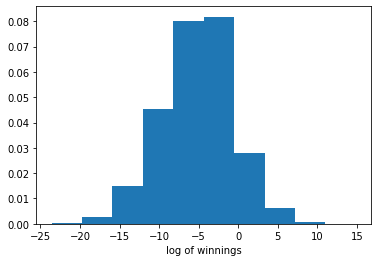

In [50]:
plt.hist(np.log(np.array(x)), density=True)
plt.xlabel("log of winnings")